# Querying the FASTDB database directly using the API

For this to work, you must have an account on the DESC TOM. If you need one and don't have one, contact Rob Knop or Liz Buckley-Geer (e.g. on Slack).

There is currently a simple REST API https://github.com/LSSTDESC/tom_desc/tree/fastdb_dev/fastdb_api which is instantiated using 

```
data_access = FASTDB()
```

This API hides the need to know how to use a REST interface.

The API takes care of authenticating you to the database. In order for this to work you need to have an `.fastdbservices.ini` in your `$HOME` area.

`cat ~/.fastdbservices.ini`
```
[fastdb]
user=buckley
passwd=xxxxx
```

## Fast Queries

For fast queries, you can use the `submit_short_query` method. You call this method with the query you want to run, and get back the results of your query. This is documented with examples below.

## Long Queries

The web proxy to the FASTDB will time out if a request takes more than 5 minutes. So, if your SQL query is going to run more than a couple of minutes, the  `submit_short_query` method won't work.

To handle this, there's another interface that lets you submit a query (or a series of queries). They will all run in one transaction, so you can do things like create temporary tables with these queries. After submitting the query, you'll get back a query id, which you can use to check the status of your query, and (if it's done) to get the results. On the back end, there is a process that will run these slow queries. (At the moment, there's only a single thread running those queries, but in the future this will be multi-threaded so one person submitting a 3-day query doesn't block everybody else.)

This second interface is also documented with examples below.

## The Fast Query Interface

If your query is going to take less than a couple of minutes, this is the one to use. To run it, you use the `submit_short_query` method. You call this method with the query you want to run:

* query: str or list of str. The SQL query to run, or a list of queries to run in order in a single transaction.
* subdict: dict, list of dict, or None (default). You can include %(varname)s in your SQL query, where varname can be any string. Then, in your subdict, you should have varname as a key, and the value is what should be substituted into the query. (These are as used in the psycopg2 cursor "execute" method.)

You should practice good SQL hygiene and make sure to use subdict to interpolate any calculated or user-inputted parameters. However, don't worry too much, the back-end uses a read-only postgres user but you can still create temporary tables.

Here is a simple python notebook that selects some dia_objects and gets the dia_sources associated with them and plots some light curves.  It uses the dia_source_current view that has been defined using the Create view tool. 


In [1]:
from fastdb_api import FASTDB
from matplotlib import pyplot as plt
import time
import pandas
import io
import math

# Prevent matplot lib complaining about too many figures

plt.rcParams.update({'figure.max_open_warning': 0})

# Create a data access object that will authenticate to the database

data_access = FASTDB()

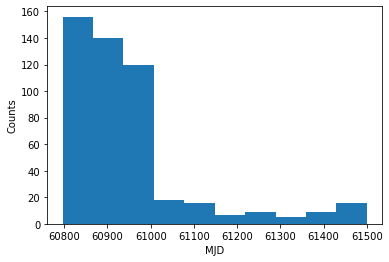

In [2]:
# Select all columns from the dia_object table for objects from first season that have more that 5 observations

query = "select * from dia_object where season=1 and nobs>5"
dia_object_data = data_access.submit_short_query(query)

mjd = []

# Display the results

for dq in dia_object_data:
    mjd.append(dq['ra_dec_tai'])
fig, ax = plt.subplots()
ax.hist(mjd)
ax.set_xlabel('MJD')
ax.set_ylabel('Counts')
plt.show()

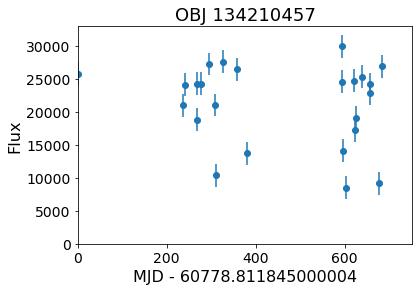

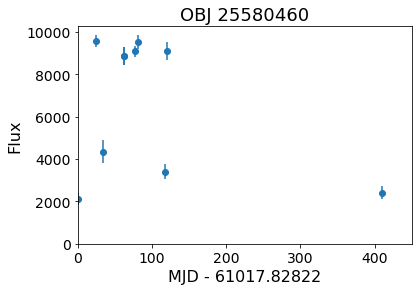

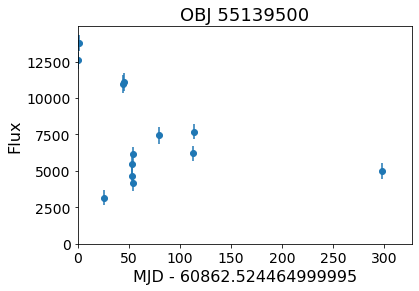

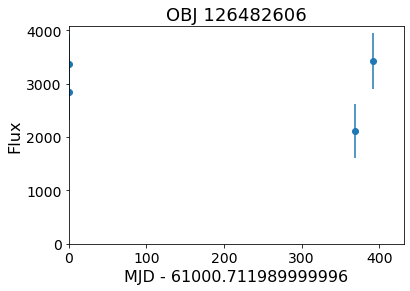

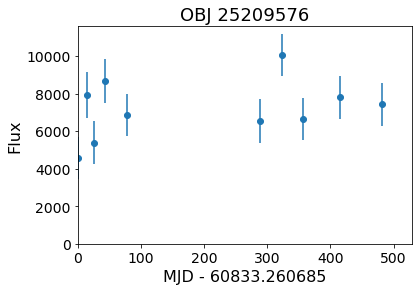

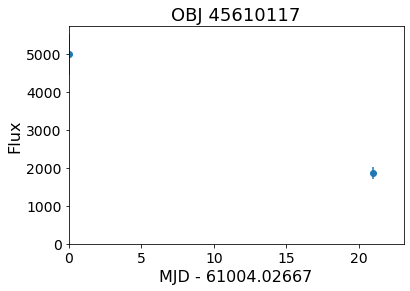

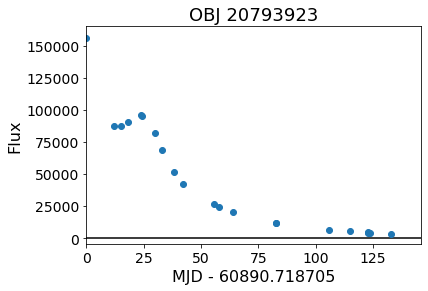

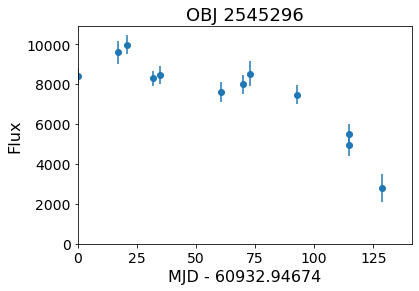

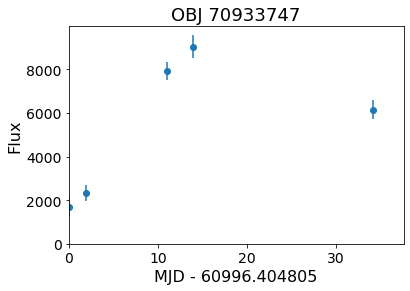

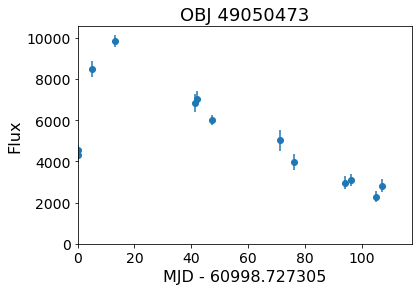

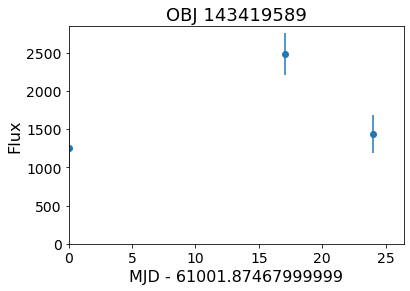

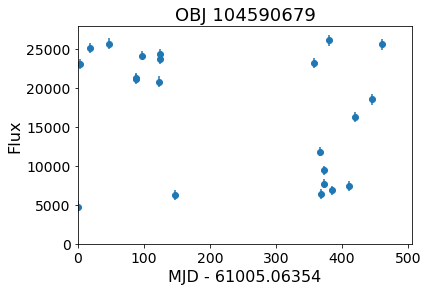

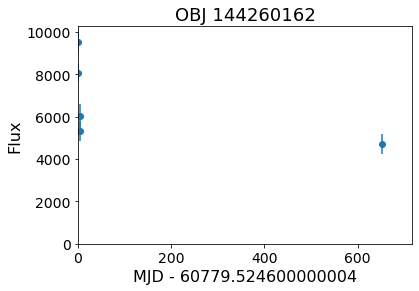

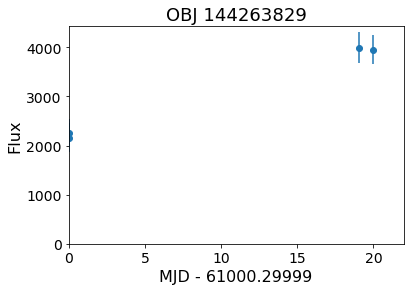

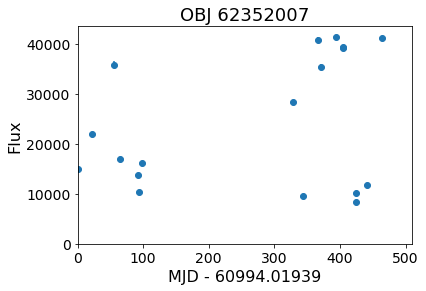

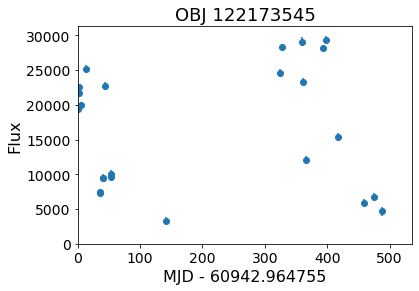

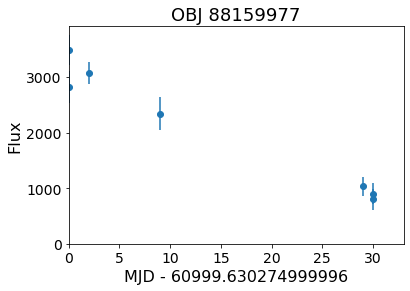

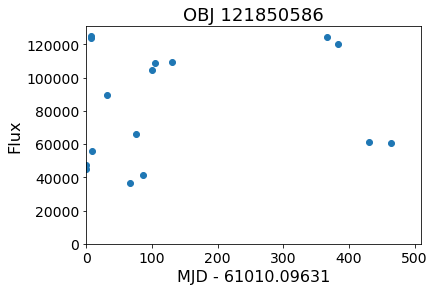

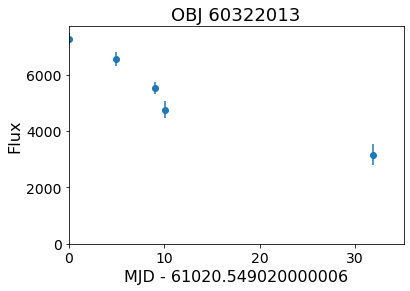

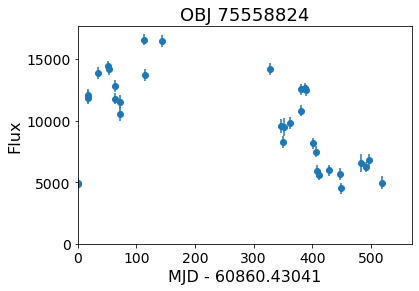

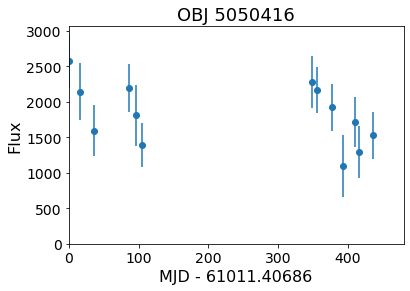

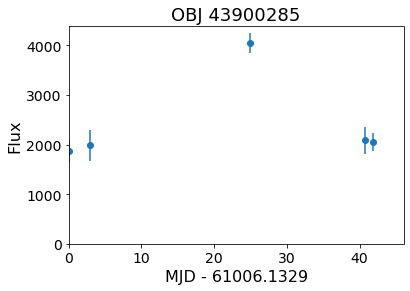

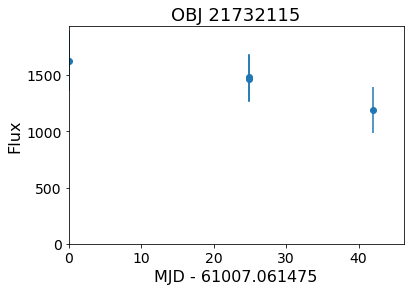

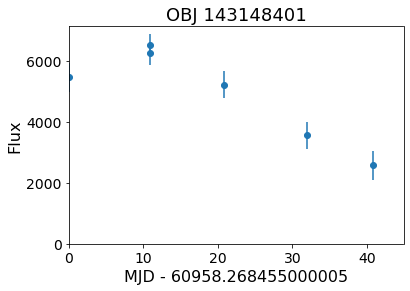

In [3]:
# Select all the DIA Objects from Season 1 that have at least 5 observations and an MJD between 61000 and 61100

query = "select * from dia_object where season=1 and nobs>5 and ra_dec_tai between 61000.0 and 61100.0"

dia_object_data = data_access.submit_short_query(query)

# This is an example of performing a query that stores the results in a temporary table that you can then access 
# via a second query. The temporary table is deleted after the queries are complete.
# The first query fetches the MJD, the flux and the flux error from the DIA Source table for the objects we selected 
# in the previous query. The first query requires us to provide the object id so we will use the subdict argument of
# the submit_short_query method. Note that even though the second query has no parameters we need to provide an empty
# dictionary otherwise the code will complain.

# Note that you cannot run multiple queries that each want to return results because the database can only return the results
# from the final query.If you want to run multiple queries that each return results then you need to run multiple instances
# of the submit_short_query method

q = ["select mid_point_tai,ps_flux,ps_flux_err into temp table my_temp_table from dia_source_current\
    where dia_object=%(obj_id)s and ps_flux > 0 and\
     filter_name = 'i'", "select * from my_temp_table"]

for d in dia_object_data:

    dia_source_data = data_access.submit_short_query(q, subdict=[{'obj_id': d['dia_object']},{}])
    
    mjd = []
    flux = []
    flux_err = []
    
    for dq in dia_source_data:
        mjd.append(dq['mid_point_tai'])
        flux.append(dq['ps_flux'])
        flux_err.append(dq['ps_flux_err'])
    
    
    delta_mjd = []

    if len(mjd) >= 2:
        mint = min(mjd)
        maxt = max(mjd)
        for dm in mjd:
            delta_mjd.append(dm-mint)
        dt = maxt-mint
        mint -= 0.05*dt
        maxt += 0.05*dt
        fig, ax = plt.subplots()
        ax.errorbar(delta_mjd,flux,yerr=flux_err,fmt='o')
        ax.set_xlabel('MJD')
        ax.set_title( f'OBJ {d["dia_object"]}', fontsize=18 )
        ax.set_xlabel( f'MJD - {mint}', fontsize=16 )
        ax.set_ylabel( 'Flux', fontsize=16 )
        ax.tick_params( 'both', labelsize=14 )
        ymin, ymax = ax.get_ylim()
        if ymin > 0:
            ax.set_ylim( 0, ymax )
        else:
            ax.axhline( color='black' )
        ax.set_xlim( 0, maxt-mint )
        plt.show()
    

## The Long Query Interface

This next example assumes that you are going to submit a query that may take longer to run that the browser time-out limit.

* You use `submit_long_query` to submit your query (or queries) and get an id for your query. Save this id, because it's the only way to get the results of your query later! (At the moment, there's no interface to see all queries you've submitted.)
* Wait
* Use `check_long_sql_query(queryid)` to see if your query is done. If so, go on. If not, wait, and repeat this step.
* Use `get_long_sql_query(queryid)` to get the results of your query

### Submitting a query

* query: str or list of str. The SQL query to run, or a list of queries to run in order in a single transaction. Note that only the last query will be able to return data
* subdict: dict, list of dict, or None (default). You can include %(varname)s in your SQL query, where varname can be any string. Then, in your subdict, you should have varname as a key, and the value is what should be substituted into the query. (These are as used in the psycopg2 cursor "execute" method.) If using lists, the length of this list and the list in query must be the same.
* format: str : the format you will want your data returned in; one of csv, pandas, or numpy. If csv, you will get back text data in csv format (with actual commas separating the fields). If pandas, you will get back a binary blob that is a pickled pandas object. If numpy, you will get back an error, because that format isn't implemented yet. If you don't specify format, it will default to csv (the least efficient, but most likely to be readable, format).

In [4]:
# Here is our query

q = "select * from dia_source_current where mid_point_tai >= 61200 and ps_flux > 0 and filter_name = 'i'"

# Submit the query. If all is okay then you will get back the query ID. Save this as you need it for the next step.
# If something went wrong then you will get an error

queryid = data_access.submit_long_query(q)

Submitted query cae3a108-5471-4bf0-b578-37b405ab9b8e


### Checking the status of your query

Use the `check_long_sql_query(queryid)` to see if your query is done. You will get one of four responses

* `queued` : your query is waiting to run
* `started` : your query has started, but not finished
* `finished` : your query is finished
* `error` : something went wrong, perhaps an SQL error.

Repeat this until you get a finished or error status. Don't do this in a rapid while loop! You shouldn't post to this API more than once a minute. The backend process that actually performs the queries only looks for things to do once a minute, so in the best case it will take up to a minute for your query to start. Once your query has started, if you expect it to finish in less than a minute or so, you would have been better off using the fast query interface described above. 

If after a long time your query is not started, it's possible that the back-end process that actually makes these queries is not running. There's no easy way to diagnose that other than talking to Liz (e.g. on Slack). It's also possible that somebody else has submitted a really long query, and your query is waiting. At the moment, only a single query can run at once.

If your query has started, but not finished, nor errored out, it's possible that something went wrong that failed to generate an error message; you should only suspect this if there has been ample time to run your query (which could be a lot of time). There's no easy way to diagnose this other than bugging Liz.

In [5]:
status = ''
while not status == 'finished':
    data = data_access.check_long_sql_query(queryid)
    
    status = data['status']
    
    if status == 'error':
        print( f"Got error response\n{json.dumps(data,indent=2)}" )
    else:
        submittime = data['submitted']
        queries = data['queries']
        subdicts = data['subdicts']

        print( f"Query was submitted: {submittime}" )
        print( f"Sequence of queries to run:" )
        for q, s in zip( queries, subdicts ):
            print( f"    {q}   {s}" )

        if  status == 'queued':
            print( f"Query queued" )
            time.sleep(30.)
        if status == 'started':
            print( f"Query started: {data['started']}" )
            time.sleep(30.)
        if status == "finished":
            print( f"Query finished: {data['finished']}" )


Query was submitted: 2024-12-03T23:01:49.741149+00:00
Sequence of queries to run:
    select * from dia_source_current where mid_point_tai >= 61200 and ps_flux > 0 and filter_name = 'i'   {}
Query queued
Query was submitted: 2024-12-03T23:01:49.741149+00:00
Sequence of queries to run:
    select * from dia_source_current where mid_point_tai >= 61200 and ps_flux > 0 and filter_name = 'i'   {}
Query finished: 2024-12-03T23:02:15.893056+00:00


### Reading the results

Use `get_long_sql_query(queryid)` to get the results of your query. 

If you get back a csv, you can make an io.StringIO object, feeding it the results of the `get_long_sql_query(queryid)`. Pass that to pandas.read_csv, and you'll get a DataFrame. This is what happens in the example below.

If you get back a binary blob, and you asked for pandas format, then you could initialize a io.BytesIO object with resp.content. Feed that BytesIO object to pandas.read_pickle(), and viola, you should have a DataFrame with the results of your query.

In [6]:
# Get the results

data = data_access.get_long_sql_query(queryid)
sio = io.StringIO( data)
df = pandas.read_csv( sio )
#Free up memory
sio = None

# Display the results
display(df)


,Unnamed: 0,uuid,dia_source,ccd_visit_id,parent_dia_source_id,season,fake_id,mid_point_tai,filter_name,ra,decl,ps_flux,ps_flux_err,snr,processing_version,broker_count,valid_flag,insert_time,dia_object
0,0,579733c6-d714-485e-a3a1-afac32898025,146761500144,NaN,NaN,1,0,61490.1940,i,184.869018,184.869018,1807.7799,376.29510,4.804155,v1_1,2,1,2024-06-11 23:20:13.392207+00:00,1467615
1,1,cfb2cf34-cfed-4270-9d5f-982b2a14bcb5,505041600084,NaN,NaN,1,0,61381.2416,i,115.159817,115.159817,2281.4840,364.06750,6.266651,v1_1,2,1,2024-06-11 23:19:34.573179+00:00,5050416
2,2,92cae896-9ea3-4f67-b258-f68087208b96,505041600088,NaN,NaN,1,0,61388.2954,i,115.159817,115.159817,2164.1500,328.86440,6.580675,v1_1,1,1,2024-06-11 23:19:34.664942+00:00,5050416
3,3,1276b006-0a1d-4057-8ab5-a853532de8f5,505041600099,NaN,NaN,1,0,61410.2855,i,115.159817,115.159817,1922.6489,330.92654,5.809896,v1_1,1,1,2024-06-11 23:21:06.359877+00:00,5050416
4,4,15dce513-f8cc-4e25-a9d7-bab56945d60a,505041600103,NaN,NaN,1,0,61426.1785,i,115.159817,115.159817,1094.1929,438.70758,2.494128,v1_1,2,1,2024-06-11 23:21:06.386884+00:00,5050416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,670,b35017bf-09fd-4a2d-a757-a63e04dcde7e,15816733300170,NaN,NaN,1,0,61472.0673,i,148.274612,148.274612,3851.6890,490.17740,7.857745,v1_1,1,1,2024-06-11 23:16:48.571542+00:00,158167333
671,671,2d28a323-4e17-422a-8605-cddcd474a81a,15816733300171,NaN,NaN,1,0,61472.0682,i,148.274612,148.274612,2825.1316,515.76100,5.477599,v1_1,1,1,2024-06-11 23:16:48.684581+00:00,158167333
672,672,1c25c7a3-f02c-4a67-a5ab-82f3e7e7b13d,15816733300175,NaN,NaN,1,0,61473.1733,i,148.274612,148.274612,3437.0030,415.14172,8.279107,v1_1,2,1,2024-06-11 23:16:48.995539+00:00,158167333
673,673,e89385b1-5b3d-4e17-aca2-9a92a0f98a48,15816733300187,NaN,NaN,1,0,61491.1297,i,148.274612,148.274612,6464.4746,488.17310,13.242177,v1_1,2,1,2024-06-11 23:16:54.421667+00:00,158167333


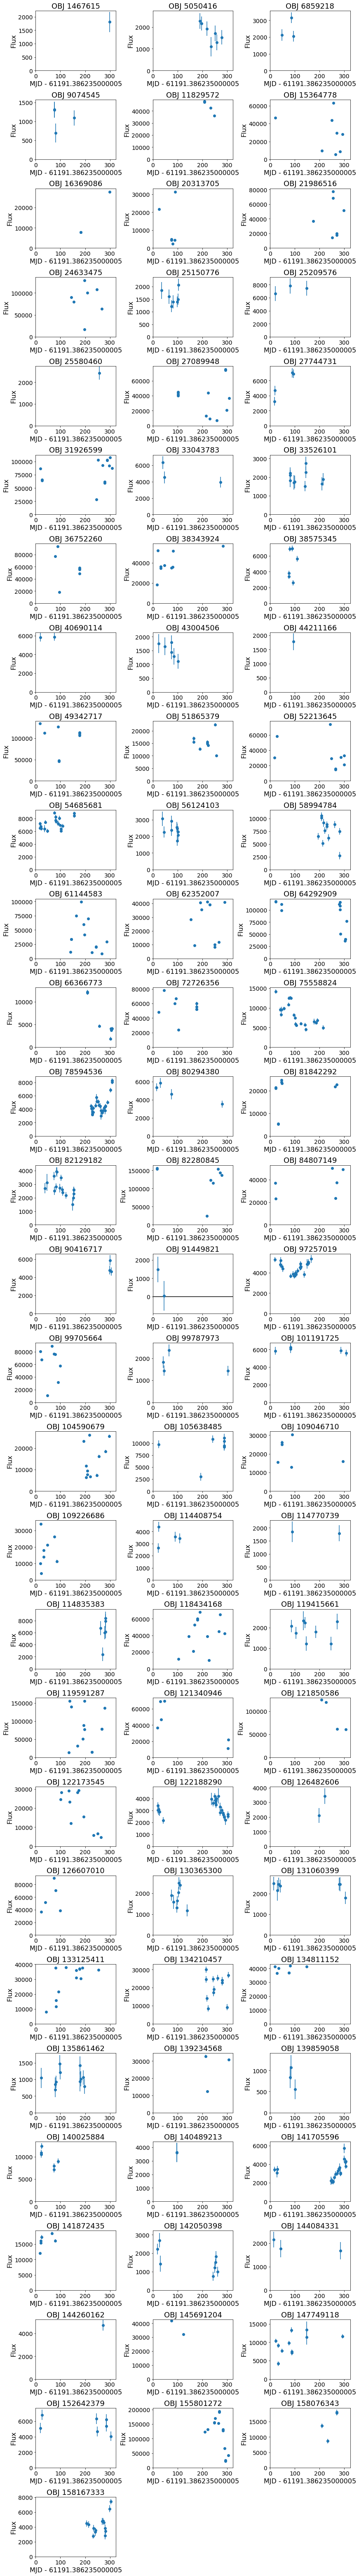

In [7]:
# Now make some light curves from the results

dia_objs = df['dia_object'].unique()
mint = df['mid_point_tai'].min()
maxt = df['mid_point_tai'].max()
dt = maxt-mint
mint -= 0.05*dt
maxt += 0.05*dt
ncols = 3
nrows = math.ceil( len(dia_objs) / ncols )
fig = plt.figure( figsize=(12,3*nrows), tight_layout=True )
for i, dia_obj in enumerate(dia_objs):
    subdf = df[ df['dia_object'] == dia_obj ]
    ax = fig.add_subplot( nrows, ncols, i+1 )
    ax.errorbar( subdf['mid_point_tai']-mint, subdf['ps_flux'], subdf['ps_flux_err'], linestyle='None', marker='o' )
    ax.set_title( f'OBJ {dia_obj}', fontsize=18 )
    ax.set_xlabel( f'MJD - {mint}', fontsize=16 )
    ax.set_ylabel( 'Flux', fontsize=16 )
    ax.tick_params( 'both', labelsize=14 )
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
        ax.set_ylim( 0, ymax )
    else:
        ax.axhline( color='black' )
    ax.set_xlim( 0, maxt-mint )
plt.show()

Here is an example that returns binary data

In [8]:
# Here is our query

q = "select * from dia_source_current where mid_point_tai >= 61200 and ps_flux > 0 and filter_name = 'i'"

# Submit the query. If all is okay then you will get back the query ID. Save this as you need it for the next step.
# If something went wrong then you will get an error

queryid = data_access.submit_long_query(q, format='pandas')

status = ''
while not status == 'finished':
    data = data_access.check_long_sql_query(queryid)
    
    status = data['status']
    
    if status == 'error':
        print( f"Got error response\n{json.dumps(data,indent=2)}" )
    else:
        submittime = data['submitted']
        queries = data['queries']
        subdicts = data['subdicts']

        print( f"Query was submitted: {submittime}" )
        print( f"Sequence of queries to run:" )
        for q, s in zip( queries, subdicts ):
            print( f"    {q}   {s}" )

        if  status == 'queued':
            print( f"Query queued" )
            time.sleep(30.)
        if status == 'started':
            print( f"Query started: {data['started']}" )
            time.sleep(30.)
        if status == "finished":
            print( f"Query finished: {data['finished']}" )


Submitted query 82cd2be6-20ef-4596-8f08-02e20be425b0
Query was submitted: 2024-12-03T23:03:08.624689+00:00
Sequence of queries to run:
    select * from dia_source_current where mid_point_tai >= 61200 and ps_flux > 0 and filter_name = 'i'   {}
Query queued
Query was submitted: 2024-12-03T23:03:08.624689+00:00
Sequence of queries to run:
    select * from dia_source_current where mid_point_tai >= 61200 and ps_flux > 0 and filter_name = 'i'   {}
Query finished: 2024-12-03T23:03:16.216139+00:00


You get back a binary blob. You can then initialize a io.BytesIO object with the data and feed that BytesIO object to pandas.read_pickle() and you will have a DataFrame with the results of your query.

In [9]:
data = data_access.get_long_sql_query(queryid)
bio = io.BytesIO(data)
df = pandas.read_pickle(bio)
#Free up memory
bio = None
display(df)

,uuid,dia_source,ccd_visit_id,parent_dia_source_id,season,fake_id,mid_point_tai,filter_name,ra,decl,ps_flux,ps_flux_err,snr,processing_version,broker_count,valid_flag,insert_time,dia_object
0,579733c6-d714-485e-a3a1-afac32898025,146761500144,None,None,1,0,61490.1940,i,184.869018,184.869018,1807.7799,376.29510,4.804155,v1_1,2,1,2024-06-11 23:20:13.392207+00:00,1467615
1,cfb2cf34-cfed-4270-9d5f-982b2a14bcb5,505041600084,None,None,1,0,61381.2416,i,115.159817,115.159817,2281.4840,364.06750,6.266651,v1_1,2,1,2024-06-11 23:19:34.573179+00:00,5050416
2,92cae896-9ea3-4f67-b258-f68087208b96,505041600088,None,None,1,0,61388.2954,i,115.159817,115.159817,2164.1500,328.86440,6.580675,v1_1,1,1,2024-06-11 23:19:34.664942+00:00,5050416
3,1276b006-0a1d-4057-8ab5-a853532de8f5,505041600099,None,None,1,0,61410.2855,i,115.159817,115.159817,1922.6489,330.92654,5.809896,v1_1,1,1,2024-06-11 23:21:06.359877+00:00,5050416
4,15dce513-f8cc-4e25-a9d7-bab56945d60a,505041600103,None,None,1,0,61426.1785,i,115.159817,115.159817,1094.1929,438.70758,2.494128,v1_1,2,1,2024-06-11 23:21:06.386884+00:00,5050416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,b35017bf-09fd-4a2d-a757-a63e04dcde7e,15816733300170,None,None,1,0,61472.0673,i,148.274612,148.274612,3851.6890,490.17740,7.857745,v1_1,1,1,2024-06-11 23:16:48.571542+00:00,158167333
671,2d28a323-4e17-422a-8605-cddcd474a81a,15816733300171,None,None,1,0,61472.0682,i,148.274612,148.274612,2825.1316,515.76100,5.477599,v1_1,1,1,2024-06-11 23:16:48.684581+00:00,158167333
672,1c25c7a3-f02c-4a67-a5ab-82f3e7e7b13d,15816733300175,None,None,1,0,61473.1733,i,148.274612,148.274612,3437.0030,415.14172,8.279107,v1_1,2,1,2024-06-11 23:16:48.995539+00:00,158167333
673,e89385b1-5b3d-4e17-aca2-9a92a0f98a48,15816733300187,None,None,1,0,61491.1297,i,148.274612,148.274612,6464.4746,488.17310,13.242177,v1_1,2,1,2024-06-11 23:16:54.421667+00:00,158167333
